In [1]:
# %load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import argparse
import random
import subprocess
import os
import time
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import esm
import biotite.structure.io as bsio
# from biopandas.pdb import PandasPdb
from pathlib import Path
from datetime import datetime

import Bio
import Bio.PDB as bp

def calculate_tm_score(
    pred_path, pdb_path, chain_id=None, use_tmalign=False, verbose=False,
    tmscore_path="/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign",
    tmalign_path="/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign.cpp"
):

    if chain_id is not None:
        raise NotImplementedError("Chain ID is not implemented for TM-score calculation.")

    # Run TMscore and capture the output
    command = [tmalign_path, pdb_path, pred_path] if use_tmalign else [tmscore_path, pred_path, pdb_path]
    result = subprocess.run(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    def print_cmd():
        print("TMscore command:")
        print(result.args)
        print("TMscore output:")
        print(result.stdout)
        print("TMscore error:")
        print(result.stderr)
    if verbose:
        print_cmd()

    # Extract TM-score from the output
    for line in result.stdout.split('\n'):
        if line.startswith("TM-score"):
            tm_score = float(line.split('=')[1].split()[0])
            return tm_score

    print_cmd()
    raise ValueError("TM-score not found in the output")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# !pip install autotime

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: False


In [9]:
from pathlib import Path
import os
import warnings
import pandas as pd
import tqdm
from Bio.PDB import PDBParser

import esm
import biotite.structure.io as bsio

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10000)
pd.set_option("max_colwidth", 100)
base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures")
SABDAB_SUMMARY_PATH = base_path / Path("sabdab_summary_after_80.tsv")
OUTPUT_PATH = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("raw")
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")

Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/sabdab_summary_after_80.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/raw
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures


In [10]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df.head(5)

Entries in summary: 177


,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,organism,heavy_species,light_species,antigen_species,authors,resolution,method,r_free,r_factor,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,seqH,seqL,full_sequence,pLDDT_before,tm_score_before,Hchain_pLDDT_before,Hchain_tm_score_before,Lchain_pLDDT_before,Lchain_tm_score_before,Hchain_pLDDT_after,Hchain_tm_score_after,Lchain_pLDDT_after,Lchain_tm_score_after
0,9fyt,I,M,0,B,protein,NaN,alpha-cobratoxin,TOXIN,07/16/25,mAbs in complex with cobratoxin at pH 4.5,Homo sapiens; Naja kaouthia,homo sapiens,homo sapiens,naja kaouthia,"Wade, J., Bohn, M.F., Laustsen, A.H., Morth, J.P.",1.55,X-RAY DIFFRACTION,0.237,0.186,False,True,IGHV1,IGLV3,Lambda,NaN,NaN,NaN,NaN,NaN,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,SSYELTQPPSVSVAPGRTATITCEGDNIGQQIVHWYQQKPGQAPVAVISSDSDRPSGIPERFSGSNSGNTATLTISRVEAGDEADYYCQVWDSGSD...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,78.051160,NaN,78.051160,0.26598,78.051160,NaN,79.375530,0.26729,87.516016,0.2284
1,9lux,A,a,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,76.059034,NaN,76.059034,0.43121,76.059034,NaN,78.084864,0.43109,NaN,NaN
2,9lux,B,b,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,76.059034,NaN,76.059034,0.43121,76.059034,NaN,78.280960,0.43079,NaN,NaN
3,9lux,C,c,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,70.152480,NaN,70.152480,0.47795,70.152480,NaN,76.726656,0.47651,NaN,NaN
4,9lux,D,d,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,70.152480,NaN,70.152480,0.47795,70.152480,NaN,76.489022,0.46957,NaN,NaN


In [13]:
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import pandas as pd

def fetch_and_parse_sequences(df, pdb_dir):
    parser = PDBParser(QUIET=True)
    output_rows = []

    for _, row in df.iterrows():
        pdb_id = row['pdb'].lower()
        pdb_path = pdb_dir / f"{pdb_id}.pdb"

        chain_type_map = {}
        for col in ['Hchain', 'Lchain', 'antigen_chain']:
            if pd.notna(row[col]):
                chains = str(row[col]).replace(" ", "").split('|')
                for ch in chains:
                    chain_type_map[ch] = col

        try:
            structure = parser.get_structure(pdb_id, pdb_path)
        except Exception as e:
            print(f"Error parsing PDB {pdb_id}: {e}")
            continue

        model = structure[0] 

        for chain in model:
            chain_id = chain.get_id()
            if chain_id in chain_type_map:
                seq = ""
                for residue in chain:
                    if residue.has_id('CA'): 
                        resname = residue.get_resname()
                        try:
                            seq += seq1(resname)
                        except KeyError:
                            print(f"Warning: Unknown residue {resname} in chain {chain_id} of PDB {pdb_id}. Skipping.")
                            continue

                output_rows.append({
                    "pdb": pdb_id,
                    "chain": chain_id,
                    "chain_type": chain_type_map[chain_id],
                    "sequence": seq,
                    "resolution": row['resolution']
                })

    return pd.DataFrame(output_rows)

In [ ]:
# df_with_seq = fetch_and_parse_sequences(df, PDB_FILES_PATH)
# df = df_with_seq.copy()
# df.to_csv(path_or_buf=base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

Using cuda


In [14]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PATH):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    out_path = out_dir / f"{pdb_id.lower()}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = struct.b_factor.mean()
    tm_score = calculate_tm_score(
        pred_path=out_path,
        pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    return pLDDT, tm_score

In [15]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PATH):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    model.ttt(sequence)
    pLDDT_after, tm_score_after = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after, tm_score_after

## Before

In [55]:
df.head(5)

,pdb,chain,chain_type,sequence,resolution
0,9fyt,B,antigen_chain,IRCFITPDITSKDCPNGHVCYTKTWCDAFCSIRGKRVDLGCAATCPTVKTGVDIQCCSTDNCNPFPTRKRP,1.55
1,9fyt,I,Hchain,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,1.55
2,9fyt,M,Lchain,SSYELTQPPSVSVAPGRTATITCEGDNIGQQIVHWYQQKPGQAPVAVISSDSDRPSGIPERFSGSNSGNTATLTISRVEAGDEADYYCQVWDSGSD...,1.55
3,9lux,A,Hchain,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,1.85
4,9lux,B,Hchain,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,1.85


In [ ]:
num_of_low = 0
col = 'sequence'

In [ ]:
# for i, row in df.iterrows():
#     if pd.notna(row.get("pLDDT_before")) :
#         continue
#     if pd.isna(row[col]):
#         continue
    
#     pdb_id = str(row.get("pdb"))
#     tag = row.get("chain_type", "unknown")
    
#     seq = str(row[col]).strip().upper()
#     tag_chain = f'{tag}_{row["chain"]}'
    
#     try:
#         pLDDT_before, tm_score_before = predict_structure(model, seq, pdb_id, tag=f'{tag_chain}_before_ttt', out_dir=OUTPUT_PATH)
#         df.at[i, f'pLDDT_before'] = pLDDT_before
#         df.at[i, f'tm_score_before'] = tm_score_before
#         if pLDDT_before < 70:
#             num_of_low+=1
#             print(num_of_low)
#             df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)
#     except Exception as e:
#         warnings.warn(f"{pdb_id}{tag_chain}: {e}")
            
# df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

28it [01:02,  1.60s/it]

## After

In [ ]:
c =0 
for i, row in df.iterrows():
    if len(str(row[col]).strip().upper()) > 500:
        continue
    c+=1
    pdb_id = str(row.get("pdb"))

    if pd.isna(row[col]):
        continue
    
    tag = row.get("chain_type", "unknown")
    seq = str(row[col]).strip().upper()
    tag_chain = f'{tag}_{row["chain"]}'

    try:
        pLDDT_after, tm_score_after = fold_chain(seq, pdb_id, model=model, tag=tag)
        df.at[i, 'pLDDT_after'] = pLDDT_after
        df.at[i, 'tm_score_after'] = tm_score_after
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag}: {e}")
    if c % 50 == 0:
        df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

## Plots

KeyError: 'pLDDT_after'

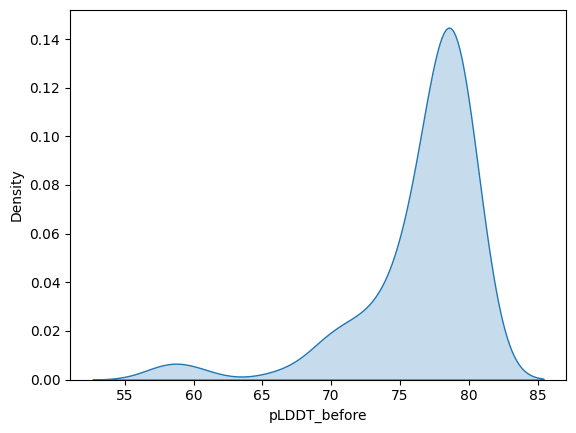

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.kdeplot(df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

In [18]:
sns.kdeplot(df['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(df['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

NameError: name 'sns' is not defined

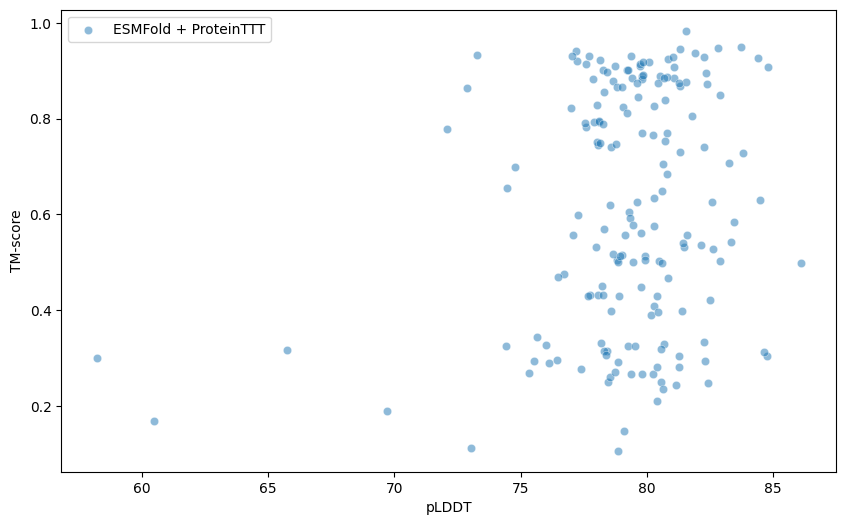

In [34]:
plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Hchain_pLDDT_before', y='Hchain_tm_score_before', data=df, label='ESMFold', alpha=0.5)
sns.scatterplot(x='Hchain_pLDDT_after', y='Hchain_tm_score_after', data=df, label='ESMFold + ProteinTTT', alpha=0.5)
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

In [30]:
rows = df.dropna(subset=['Hchain_pLDDT_before', 'Hchain_tm_score_before'])

In [32]:
from scipy.stats import pearsonr
pearsonr(rows['Hchain_pLDDT_after'], rows['Hchain_tm_score_after'])

PearsonRResult(statistic=0.21238543787315534, pvalue=0.004656368576873335)

Text(0, 0.5, 'TM-score difference after and before ProteinTTT')

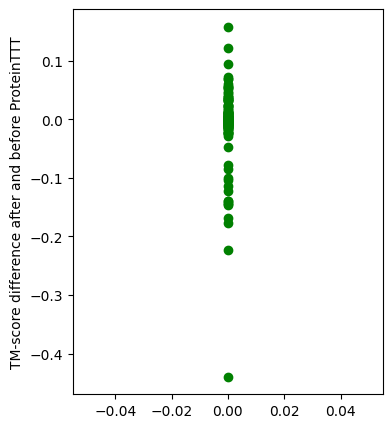

In [44]:
#tm-score difference before and after ProteinTTT 1d plot
df['Hchain_tm_score_diff'] = df['Hchain_tm_score_after'] - df['Hchain_tm_score_before']
plt.figure(figsize=(4, 5))
plt.scatter(np.zeros_like(df['Hchain_tm_score_diff']), df['Hchain_tm_score_diff'], color='green')
plt.ylabel('TM-score difference after and before ProteinTTT')